# Process ch 1-4 with changing watertank shift
here I will process channel 1-4 with the changing watertank shift.
So the watertank value measurement time will fit to the DTS measurement time.
This will give some data gaps, because the Watertank temperature is not always avaible.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file

import plotly
import plotly.express as px
import kaleido

# reloads modules if something is changed in them <-- thats real magic
# I can adapt my functions and dont have to restart the notebook to load the new stuff
# be carefull with dependencies, when using from ... import ...
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data, calc_mean_for_each_segment, plot_segments_mean_correction, const_shift_data, add_nan_val_in_datagaps, carpet_plot_with_gaps

plot_save=True #True False
show_large_plot=False #True False
save_data=True #True False
fast_calc=False #True False; shortens the data, dont use it with save_data=True

path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
importer = "pickle" #csv pickle #does not work for tlogger at the moment

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [2]:
# Load pickle Data
if importer == "pickle":
    data_all = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all")

# delete egrt cable channels
for egrt_chan in ["5","6","7","8"]:
    del data_all[egrt_chan]

In [3]:
# divide into segments of the same kalibration (QuickStart)
# "22-07-2021 13:30:29" angepasst, sodass es besser zu Daten passt
# "14-07-2021 14:16:59" angepasst, sodass es besser zu Daten passt
string=["2020-12-09 11:02:45", "2021-04-07 12:43:35", "2021-04-26 10:57:11",
    "2021-04-28 09:41:06", "2021-05-20 16:02:01", "2021-06-01 15:06:12", "14-07-2021 14:16:59", "22-07-2021 13:30:29"]
#string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "22-07-2021 11:50:00", "2021-08-02 11:08:00"] #same string as for ch 5-8
#string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "2021-08-02 11:08:00"] #adapted for ch 1-4; man könnte auch einfach alle weglassen
dates=[pd.to_datetime(s) for s in string] #also used later for plotting
first_date=data_all["1"].index[0] # first_date is before first string
last_date=data_all["4"].index[-1]

calibration_segments = []
first_segment=[first_date, dates[0]] # first_date is before first string
last_segment=[dates[-1],last_date]

calibration_segments.append(first_segment)
for i in range(0,len(dates[1:])): #skip first one because its first_segment
    segment = [dates[i], dates[i+1]]
    calibration_segments.append(segment)
calibration_segments.append(last_segment)



In [4]:
#used for calculating segment wise mean
#for all segments before water tank logger measurements I need to use the first segment
calibration_segments_in_logger_range=calibration_segments[6:]
dates_in_logger_range = dates[5:]

## Raw data

In [5]:
# Correction Segments
def color_cable_pos(calibration_segment, alph, axs, ymax=30, ymin=20, col="black", label_name="none", label=False):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    start_len = calibration_segment[0]
    end_len = calibration_segment[1]
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

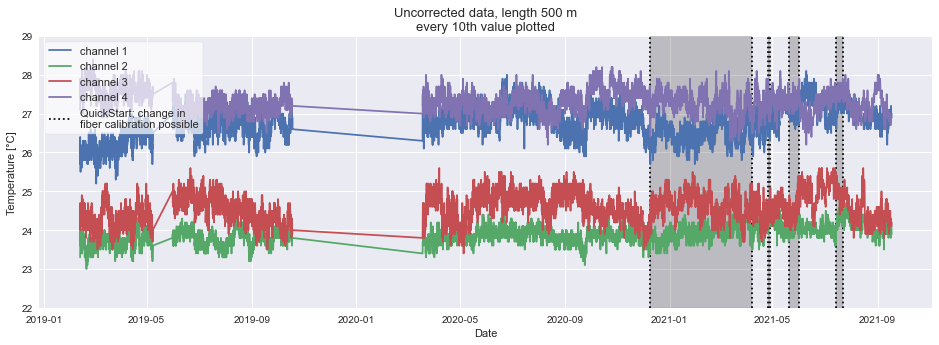

In [6]:
# Plot raw Data
length=500
from_date=0
ymin=22
ymax=29
x=10 #plot every x value

fig,axs=plt.subplots(1,1,figsize=(16,5))
# plot QuickStart positions
axs.vlines(dates,ymin,ymax,colors="black",linestyle=":",label="QuickStart; change in \nfiber calibration possible")

# plot data
for chan in ["1","2","3","4"]:
    val=round(data_all[chan][length][from_date:][::x],1) #nur jeder x Wert
    axs.plot(val.index,val.values,label=f"channel {chan}")

# Color plot
# Ich muss anscheinend hier axs explicit einfügen
alph=0.0
for segment in calibration_segments:
    color_cable_pos(segment,alph,ymax=ymax,ymin=ymin,axs=axs)
    if alph == 0.0:
        alph+=0.2
    elif alph == 0.2:
        alph=0.0
if x!=1:
    axs.set_title(f"Uncorrected data, length {length} m\nevery {x}th value plotted", fontsize=13)
else:
    axs.set_title(f"Uncorrected data, length {length} m", fontsize=13)
axs.set_xlabel("Date")
axs.set_ylabel("Temperature [°C]")
axs.set_ylim(ymin,ymax)
legend = plt.legend(fontsize=11, title_fontsize=12,frameon=True,loc="upper left")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7) #not supported with eps

if plot_save:
    plt.savefig(r"pictures\raw_data_ch14.png")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\raw_data_ch14.pdf", format="pdf",bbox_inches="tight")
plt.show()

# peak nach unten anfang 2021, nochmal genauer angucken plots über die tiefe von einem datum angucken

# Schwankungen sind teilweise entgegengestzt von einaneder


In [7]:
# import tlogger
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

df_Tlogger_PT100

,Channel1-Watertank_PT100,Channel2-Air,Channel1-PT100_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-09-17 12:04:53,20.3,NaN,20.3
2021-09-17 12:07:53,20.3,NaN,20.3
2021-09-17 12:10:54,20.3,NaN,20.3
2021-09-17 12:13:54,20.3,NaN,20.3


## Aligning

In [8]:
# 60s
data_all_processed=deepcopy(data_all)
a = data_all_processed
#delete some dates so all gaps are alligned

# allign first dates
a["1"] = a["1"].drop(a["1"].index[0],axis=0)

a["1"] = a["1"].drop(a["1"].index[274],axis=0)
a["2"] = a["2"].drop(a["2"].index[274],axis=0)
a["3"] = a["3"].drop(a["3"].index[274],axis=0)

a["1"] = a["1"].drop(a["1"].index[4263],axis=0)
a["2"] = a["2"].drop(a["2"].index[4263],axis=0)
a["4"] = a["4"].drop(a["4"].index[4263],axis=0)

a["1"] = a["1"].drop(a["1"].index[12485],axis=0)

a["1"] = a["1"].drop(a["1"].index[20211],axis=0)
a["2"] = a["2"].drop(a["2"].index[20211],axis=0)
a["3"] = a["3"].drop(a["3"].index[20211],axis=0)

# only measurements from 29.01.2020 are droped here, because they are not alligned
a["1"] = a["1"].drop(a["1"].index[20215 : 20217],axis=0)
a["2"] = a["2"].drop(a["2"].index[20215 : 20217],axis=0)
a["3"] = a["3"].drop(a["3"].index[20215 : 20218],axis=0)
a["4"] = a["4"].drop(a["4"].index[20215],axis=0)

a["1"] = a["1"].drop(a["1"].index[20217],axis=0)

a["1"] = a["1"].drop(a["1"].index[21171],axis=0)
a["2"] = a["2"].drop(a["2"].index[21171],axis=0)
a["3"] = a["3"].drop(a["3"].index[21171:21173],axis=0)
a["4"] = a["4"].drop(a["4"].index[21171],axis=0)

a["1"] = a["1"].drop(a["1"].index[40532],axis=0)
a["2"] = a["2"].drop(a["2"].index[40532],axis=0)
a["3"] = a["3"].drop(a["3"].index[40532],axis=0)
a["4"] = a["4"].drop(a["4"].index[40532],axis=0)

a["1"] = a["1"].drop(a["1"].index[44126],axis=0)
a["2"] = a["2"].drop(a["2"].index[44126],axis=0)
a["3"] = a["3"].drop(a["3"].index[44126],axis=0)
a["4"] = a["4"].drop(a["4"].index[44126],axis=0)

a["1"] = a["1"].drop(a["1"].index[53895],axis=0)

a["1"] = a["1"].drop(a["1"].index[54822],axis=0)

a["1"] = a["1"].drop(a["1"].index[56698],axis=0)
a["2"] = a["2"].drop(a["2"].index[56698],axis=0)

a["1"] = a["1"].drop(a["1"].index[56700],axis=0)

a["1"] = a["1"].drop(a["1"].index[58407],axis=0)
a["2"] = a["2"].drop(a["2"].index[58407],axis=0)

a["1"] = a["1"].drop(a["1"].index[58678:58681],axis=0)
a["2"] = a["2"].drop(a["2"].index[58678:58682],axis=0)
a["3"] = a["3"].drop(a["3"].index[58678:58680],axis=0)
a["4"] = a["4"].drop(a["4"].index[58678:58680],axis=0)

a["1"] = a["1"].drop(a["1"].index[59747],axis=0)

a["1"] = a["1"].drop(a["1"].index[62154],axis=0)
a["2"] = a["2"].drop(a["2"].index[62154],axis=0)
a["3"] = a["3"].drop(a["3"].index[62154],axis=0)

# do not change order of these, because this would change the indexes for the others
a["1"] = a["1"].drop(a["1"].index[20216],axis=0)
a["2"] = a["2"].drop(a["2"].index[20216],axis=0)
a["3"] = a["3"].drop(a["3"].index[20216],axis=0)
a["4"] = a["4"].drop(a["4"].index[20216],axis=0)


############needs to be adapted with every new import##################
a["1"] = a["1"].drop(a["1"].index[-1],axis=0)
a["2"] = a["2"].drop(a["2"].index[-1],axis=0)
#########################################################################

In [9]:
data_all_processed_withoutTlogger = deepcopy(data_all_processed)
data_all_processed = cut_dataframe_to_range_tlogger(channels=["1","2","3","4"],data=data_all_processed,watertank_T_range_min=watertank_T_range_min, watertank_T_range_max=watertank_T_range_max, do_check=False)

In [10]:
if show_large_plot:     
    carpet_plot_with_gaps(data_all_processed_withoutTlogger,["1","2","3","4"],title_prefix="Raw Temperature ",
                         vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\raw_data_ch14_carpet.png")
        plt.savefig(r"..\Masterthesis_tex\appendix\raw_data_ch14_carpet.pdf", format="pdf",bbox_inches="tight")
    plt.show()

In [11]:
# Check my processed data
print("Check data_all_processed:")
my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed)

print()
print("Check data_all_processed_withoutTlogger:")
my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed_withoutTlogger)

Check data_all_processed:
Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed

Check data_all_processed_withoutTlogger:
Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [12]:
if fast_calc:
    for chan in data_all_processed_withoutTlogger.keys(): #only use every 10s value at the moment to make calcukations faster
        data_all_processed_withoutTlogger[chan] = data_all_processed_withoutTlogger[chan][::10]

## Calculate offset and shift

In [13]:
# 60s
watertank_len=[71] # position DTS cable, where it is in watertank
# Wie habe ich aktuell die Wassertank positionen bestimmt: 
# watertank angeguckt und die position finden wo starke änderrungen sind über die Zeit sin --> draußen
# Zwei bis drei Längeneinheiten richtung DTS Gerät gegangen, dort sind dann keine starken Änderrungen über die Zeit 
    # --> Wassertankposition
# Dann die Dataframes von den Channeln die ich mittele so bearbeiten, dass genau die Wassertank positionen gemittelt werden
    # ein parr Längen /Spalten entfernt
# Positionen sind nicht ganz richtig, oder Längen die vom DTS Kabel generiert wurden stimmen nicht

# Correction for waterteank temp difference
data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger_PT100, channels=["1","2","3","4"], watertank_len=watertank_len, watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Performance warning ist denke ich nicht so wichtig

### Process ch 1-4 with mean watertank shift
here I will process channel 1-4 with the mean watertank shift.
Therefore I will divide the data in different "QuickStart" sets.
##### Plot: Is shift time dependent

In [14]:
result = calc_mean_for_each_segment(["1","2","3","4"], calibration_segments_in_logger_range, watertank_diff_log_data_all, watertank_len)
calibration_segments_mean_correction_real_data = result[0]
# only for finding correspnfing values in watertank_diff_log_data_all; not in data_all !!!
calibration_segments_mean_correction_real_data_dates = result[1] 
del result

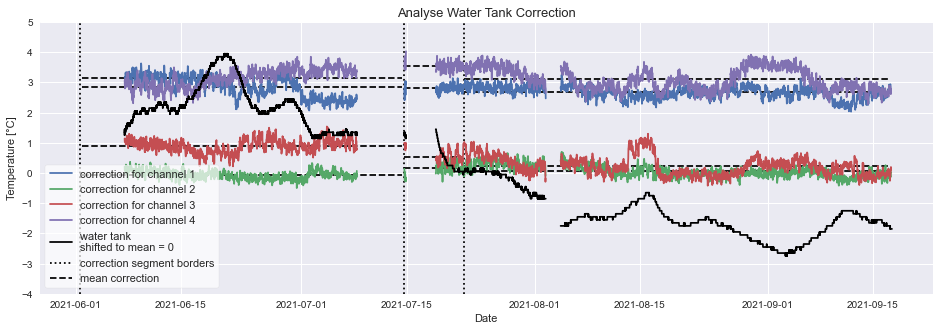

In [15]:
plot_segments_mean_correction(calibration_segments_mean_correction_real_data,dates_in_logger_range,calibration_segments_mean_correction_real_data_dates,
    watertank_diff_log_data_all,df_Tlogger_PT100,watertank_len,ymax=5, ymin=-4)


if plot_save:
    plt.savefig(r"pictures\analyse_watertank_correction_ch14.png",bbox_inches="tight")
    plt.savefig(r"..\Masterthesis_tex\figs\chap3\analyse_watertank_correction_ch14.pdf", format="pdf",bbox_inches="tight")

plt.show()

In [16]:
# add shift value for segments, which can be calibrated from real data (segments before first water tank measurements)
calibration_segments_mean_correction_all_segments = {}
n_segments = 6 # number of segments before the first segment with real data
for chan in calibration_segments_mean_correction_real_data.keys():
    real_val_chan = calibration_segments_mean_correction_real_data[chan] #the segment correction values from the segments with real data
    all_segments_val_chan=[]
    for i in range(n_segments):
        all_segments_val_chan.append(real_val_chan[0]) # use first segment with real data for all segments before
    
    for i in range(len(real_val_chan)):
        all_segments_val_chan.append(real_val_chan[i]) # add segments with real data to new list
    
    calibration_segments_mean_correction_all_segments[chan] = all_segments_val_chan

In [17]:
calibration_segments_mean_correction_real_data

{'1': [2.8562093862815887, 2.8051315789473685, 2.6705860805860806],
 '2': [-0.06502890173410392, 0.16258771929824603, 0.06535612535612546],
 '3': [0.8965437454808388, 0.5408333333333338, 0.2307369706840392],
 '4': [3.1516052060737527, 3.5408733624454154, 3.096482084690554]}

In [18]:
# px.imshow(round(data_all["2"][::10],1),zmin=20,zmax=30)

In [19]:
#

### Correct data with const shift for each segment
Advantage: no datagaps (only the ones I want to have at segment borders)
at the moment the shift is determined with the data of the atertank correction for each sgement.

But especially for the older data of chan 1 - 4 I want to determine it from the raw data. This should be also usefull for the EGRT segment due to the large data gaps.

In [20]:
# 800s
# only used every 10s value in processing the data if using fast_calc
data_all_processed_constshifted = const_shift_data(["1","2","3","4"], calibration_segments, calibration_segments_mean_correction_all_segments, data_all_processed_withoutTlogger)
if save_data:
    write_pickle(path_to_my_database + "\..\my_database_additional_local\data_ch1-4_processed_constshifted",data_all_processed_constshifted)

    copy_file(path_to_my_database + "\..\my_database_additional_local\data_ch1-4_processed_constshifted", path_to_my_database + "\data_ch1-4_processed_constshifted")

In [21]:
# sollten das resamplete nochmal überprüfen!!!!!!!!!!!!!!!
# Used later in plot
resampled_data={}
sample_hours=1 #need to play arounf with it until all chanells have same index length after resample
for chan in ["1","2","3","4"]:
    # skip first row so all dataframes start at 14:xx:xx --> resampled to same dates
    # skip last so all end at same hour; NEEDS TO BE ADAPTED WITH NEW DATA
    data_with_nan = add_nan_val_in_datagaps(data_all_processed_constshifted[chan][1:-1], minutes_gap=35)
    resampled_data[chan]=data_with_nan.resample(f"{sample_hours}H").ffill()

print("Index Length:")
for chan in ["1","2","3","4"]:
    print(f"{chan}: {len(resampled_data[chan].index)}")
    print(f"first date: {resampled_data[chan].index[0]}; last date: {resampled_data[chan].index[-1]}")
    
# original data
#print("Index Length:")
#for chan in ["5","6","7","8"]:
#    print(f"{chan}: {len(data_all_processed_constshifted[chan].index)}")
#    print(f"first date: {data_all_processed_constshifted[chan].index[1]};
#          last date: first date: {data_all_processed_constshifted[chan].index[-1]}")

7238 dates with nan have been added
7238 dates with nan have been added
7238 dates with nan have been added
7238 dates with nan have been added
Index Length:
1: 22751
first date: 2019-02-12 10:00:00; last date: first date: 2021-09-17 08:00:00
2: 22751
first date: 2019-02-12 10:00:00; last date: first date: 2021-09-17 08:00:00
3: 22751
first date: 2019-02-12 10:00:00; last date: first date: 2021-09-17 08:00:00
4: 22752
first date: 2019-02-12 10:00:00; last date: first date: 2021-09-17 09:00:00


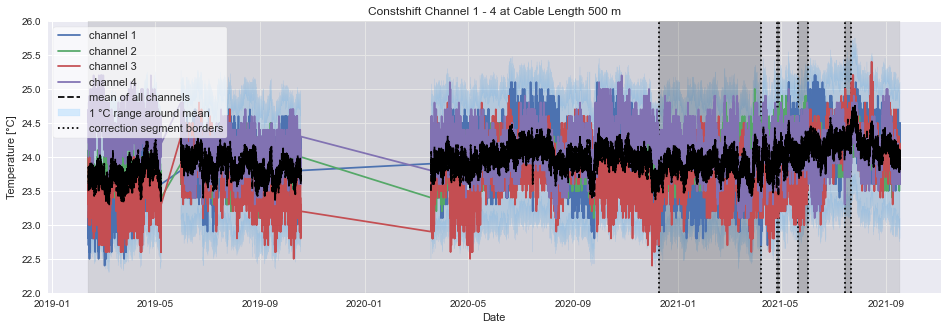

In [22]:
cable_length=500 #watertank_len[0] #watertank_len=[71]
x=1 #plot every x value, makes plot less complicated
show_segments=True
fig,axs=plt.subplots(1,1,figsize=(16,5))
# plot all channels in one axes
if x!=1:
    axs.set_title(f"Constshift Channel 1 - 4 at Cable Length {cable_length} m\nEvery {x}th Value Plotted")
else:
    axs.set_title(f"Constshift Channel 1 - 4 at Cable Length {cable_length} m")
for chan in ["1","2","3","4"]:
    #axs.plot(data_all_processed_shifted[chan][800], label=f"variable shift, channel {chan},")#, color="blue")
    axs.plot(data_all_processed_constshifted[chan][cable_length][::x],label=f"channel {chan}")#, color="green")

# mean off all channels
summe=0
# to avoid datagaps when a nan occurs; I think I need calculate this date wise.
for chan in ["1","2","3","4"]:
    summe += resampled_data[chan][cable_length]
mean=summe/4 #nan values should cause nan in mean too
mean=mean[::x]
axs.plot(mean,label=f"mean of all channels",color="black", linestyle="--")
axs.fill_between(mean.index,mean.values-1, mean.values+1,
                 #facecolor="blue", # The fill color
                 color='#7fc7ff',       # The outline color
                 alpha=0.3, label = "1 °C range around mean")          # Transparency of the fill

ymin = 22; ymax = 26
axs.set_ylim(ymin,ymax)
axs.set_ylabel("Temperature [°C]")
axs.set_xlabel("Date")
if show_segments:
    alph=0.1
    for segment in calibration_segments:
        color_cable_pos(segment,alph,ymin=ymin,ymax=ymax,axs=axs)
        if alph == 0.1:
            alph=0.25
        elif alph == 0.25:
            alph=0.1
    axs.vlines(dates,ymin,ymax,colors="black",linestyle=":", label="correction segment borders")

legend = axs.legend(fontsize=11, title_fontsize=12,frameon=True,loc="upper left")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7) #not supported with eps

if plot_save:
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\final_data_ch14_one_length.pdf", format="pdf",bbox_inches="tight")
    plt.savefig(r".\pictures\final_data_ch14_one_length.png",bbox_inches="tight")
plt.show()

# wenn ich beim letzten Segment mehr Daten habe passt es evntl besser? Oder ich muss erstes Segment noch um 0.1 mehr verschieben?
# Vergleich zwischen channel 7 und 8 für zweites segment sehr komische
# es könnte auch sein, dass channel 8 bemessen wurde als die Heizphase gerade aus gemacht wurde
# Für diesen Test sind kurze Messzeiten auf Kosten der Genauigkeit besser, da sich Temperatur ja schnell ändert
# erklärt es aber eigentlich nicht wirklich, müsste dann trotzdem viel ähnlicher sein
# es sieht so aus als ob channel 8 in segment 2 noch Manuel etwas nach unten verschoben werden sollte
# letztes Segment in channel 7 manuel nach oben verschieben?

# Extract Shaft

In [23]:
begin_shaft=200 # muss ich noch genauer nachgucken +- 2 m vielleicht
# muss auch noch genauer überprüft werden, dieser Wert beschreibt wie weit die Faser von Channel 1 und 3 geht, bevor sie wieder nach oben geht
complete_shaft_length = 860
shaft={}
for chan in ["1","2","3","4"]:
    if chan in ["2","4"]: #shorter channels
        col = data_all_processed_constshifted[chan].columns[begin_shaft:]
    if chan in ["1","3"]: #longer channels
        col = data_all_processed_constshifted[chan].columns[begin_shaft:begin_shaft + complete_shaft_length]
    shaft[chan] = data_all_processed_constshifted[chan][col]
    shaft[chan].columns = np.arange(0,shaft[chan].columns.max() + 1 - begin_shaft)
    shaft[chan].columns.names=["Depth [m]"]
    shaft[chan] = round(shaft[chan],1)


In [24]:
# Save final Temperature Shaft
if save_data:
    save_to=r"..\Alsdorf\Daten\my_database\shaft_final_temperature\old_cable\pickle"
    for chan in ["1","2","3","4"]:
        filename=f"\\Schacht_chan_{chan}"
        write_pickle(save_to+filename,shaft[chan])

    save_to=r"..\Alsdorf\Daten\my_database\shaft_final_temperature\old_cable\csv"
    for chan in ["1","2","3","4"]:
        filename=f"\\Schacht_chan_{chan}"
        shaft[chan].to_csv(save_to+filename+".csv")

In [25]:
if show_large_plot:     
    carpet_plot_with_gaps(data_all_processed_constshifted,["1","2","3","4"],title_prefix="Final Temperature ",
                          vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\final_data_ch14_carpet.png")
        plt.savefig(r"..\Masterthesis_tex\appendix\final_data_ch14_carpet.pdf", format="pdf",bbox_inches="tight")
    plt.show()